In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from PIL import Image, ImageDraw, ImageFont

In [3]:
font_dirs = ['fonts']
font_extensions = ['ttf', 'otf', 'ttc']

def is_fontfile(full_path):
    extension_dot = full_path.rfind('.')
    return (extension_dot != -1) and \
           (full_path[extension_dot + 1 :] in font_extensions)

In [4]:
alphabet = list('абвгґдеєжзиіїйклмнопрстуфхцчшщьюя1234567890№%@,.?:;"!()-\'АБВГҐДЕЄЖЗИІЇЙКЛМНОПРСТУФХЦЧШЩЬЮЯ')
np.array(alphabet)

array(['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї',
       'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х',
       'ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '0', '№', '%', '@', ',', '.', '?', ':', ';', '"',
       '!', '(', ')', '-', "'", 'А', 'Б', 'В', 'Г', 'Ґ', 'Д', 'Е', 'Є',
       'Ж', 'З', 'И', 'І', 'Ї', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р',
       'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ь', 'Ю', 'Я'],
      dtype='<U1')

In [5]:
font_files = []

for fdir in font_dirs:
    for dirname, dirnames, filenames in os.walk(fdir):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)

            if is_fontfile(full_path):
                font_files.append(full_path)
                
font_files[:5]

['fonts\\AA-BebasNeue.ttf',
 'fonts\\AA-Higherup.ttf',
 'fonts\\Academy.ttf',
 'fonts\\AcademyCTT_Bold.ttf',
 'fonts\\AcademyCTT_Italic.ttf']

In [6]:
def font_name(full_path):
    # Font name is between the last '/' and the last '.' symbols
    # Example:
    #     full path: '/usr/share/fonts/truetype/msttcorefonts/Courier_New_Bold_Italic.ttf'
    #     font name: 'Courier_New_Bold_Italic'
    return full_path[full_path.rfind('/') + 1 : full_path.rfind('.')]

# This will allow the font_name function to convert the whole
# vectors (arrays) of full pathes to font names
# font_name = np.vectorize(font_name)

# font_name(font_files)[100:110]

In [17]:
import random
from PIL import Image, ImageDraw, ImageFont, ImageOps
import cv2

background_color = 0
fill_color = 255

def char_to_image(char, font_file, img_size, scale_reduction):
    
    font_size = int(img_size * (0.9 - scale_reduction))
    
    img = Image.new('L', (img_size, img_size), background_color)
    drawer = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_file, font_size) 
    
    # Get character width and height  
    (font_width, font_height) = font.getsize(char)
  
    x = (img_size - font_width) / 2   
    y = (img_size - font_height) / 2  

    drawer.text((x, y), char, fill_color, font=font)
    
    # Convert the image to OpenCV format
    open_cv_image = np.array(img)
    
    # Binarize the image
    _, binarized_image = cv2.threshold(open_cv_image, 128, 255, cv2.THRESH_BINARY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(binarized_image, kernel, iterations=1)
    
    # Find contours in the binarized image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the bounding box of the largest contour (assuming it's the character)
    
    if not contours:
        return None
    
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image to the bounding box
    cropped_image = img.crop((x, y, x + w, y + h))
    
    bottom_padding = 2
    left_padding = (img_size - w) // 2
    top_padding = img_size - bottom_padding - h
    right_padding = img_size - left_padding - w

    padded_image = ImageOps.expand(cropped_image, (left_padding, top_padding, right_padding, bottom_padding), fill=background_color)
    
    padded_image_np = np.array(padded_image)
    
    blurred_image = cv2.GaussianBlur(padded_image_np, (3, 3), 0)
    
    blurred_image_uint8 = blurred_image.astype(np.uint8)
    
    # Конвертація зображення назад до PIL формату
    image = Image.fromarray(blurred_image_uint8)
    return image

# Зразок зображення з випадковою аугментацією розміру
augmented_image = char_to_image('д', font_files[40], 32, 1/10)

# Перевірка
augmented_image.show()

C:\Users\vvlad\AppData\Local\Temp\ipykernel_2300\4171236627.py:17: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  (font_width, font_height) = font.getsize(char)


Same letter, different fonts

C:\Users\vvlad\AppData\Local\Temp\ipykernel_17136\1610007300.py:17: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  (font_width, font_height) = font.getsize(char)


Letter 1: К
Letter 2: К


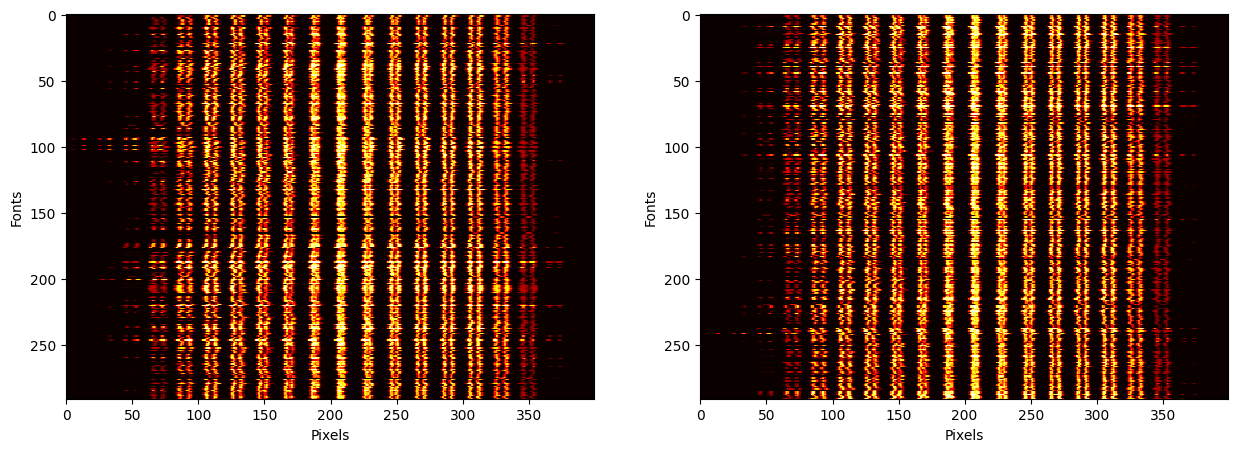

In [42]:
i = [np.random.randint(0, len(alphabet)) for _ in range(2)]

imgs = [[], []]

for _ in range(300):
    j = [np.random.randint(0, len(font_files)) for _ in range(2)]
    
    char_img_0 = char_to_image(alphabet[i[0]], font_files[j[0]], 20)
    char_img_1 = char_to_image(alphabet[i[1]], font_files[j[1]], 20)

    if char_img_0 is None or char_img_1 is None:
        continue

    imgs[0].append(np.array(char_img_0).reshape(400))
    imgs[1].append(np.array(char_img_1).reshape(400))

pylab.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

subplots = []

for k in range(2):
    subplots.append(fig.add_subplot(1,2,k+1))
    subplots[k].set_xlabel('Pixels')
    subplots[k].set_ylabel('Fonts')
    subplots[k].imshow(imgs[k], cmap='hot', interpolation='none')

print('Letter 1:', alphabet[i[0]])
print('Letter 2:', alphabet[i[1]])


C:\Users\vvlad\AppData\Local\Temp\ipykernel_17136\1610007300.py:17: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  (font_width, font_height) = font.getsize(char)


Font 1: fonts\CCHLBKI
Font 2: fonts\Lato-Medium


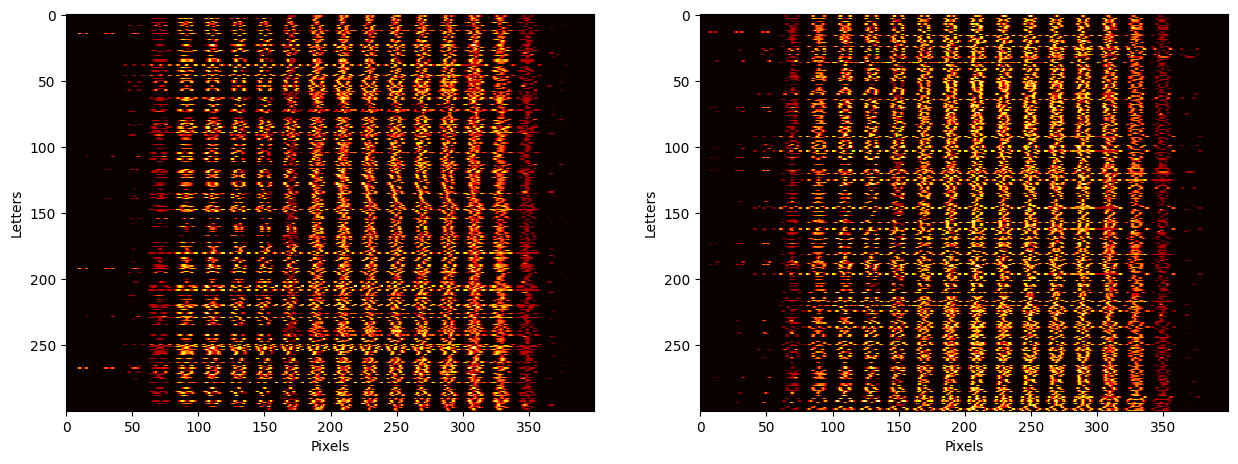

In [43]:
j = [np.random.randint(0, len(font_files)) for _ in range(2)]

imgs = [[], []]

for _ in range(300):
    i = [np.random.randint(0, len(alphabet)) for _ in range(2)]
    
    char_img_0 = char_to_image(alphabet[i[0]], font_files[j[0]], 20)
    char_img_1 = char_to_image(alphabet[i[1]], font_files[j[1]], 20)

    if char_img_0 is None or char_img_1 is None:
        continue

    imgs[0].append(np.array(char_img_0).reshape(400))
    imgs[1].append(np.array(char_img_1).reshape(400))

pylab.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

subplots = []

for k in range(2):
    subplots.append(fig.add_subplot(1,2,k+1))
    subplots[k].set_xlabel('Pixels')
    subplots[k].set_ylabel('Letters')
    subplots[k].imshow(imgs[k], cmap='hot', interpolation='none')

print('Font 1:', font_name(font_files[j[0]]))
print('Font 2:', font_name(font_files[j[1]]))


In [19]:
im_size = 32

v = []

for i in range(len(alphabet)):
    for font_file in font_files:
        for j in range(0, 5):
            letter = char_to_image(alphabet[i], font_file, im_size, j/10)
            if letter == None:
                continue
            im = np.array(letter).flatten()
            label = alphabet[i].lower()
            label_index = alphabet.index(label)
            im_with_label = np.hstack((label_index, im))
            v.append(im_with_label)

C:\Users\vvlad\AppData\Local\Temp\ipykernel_2300\4171236627.py:17: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  (font_width, font_height) = font.getsize(char)


In [45]:
import json

df = pd.DataFrame(v)
df = df.sample(frac=1)

In [ ]:
df.to_csv('uaset_extended_lower_case_size_reduction.csv', index=False)

In [ ]:
for j in range(0, 5):
    print(j)
